In [19]:
#导入必要依赖库
import torch.optim
import  torchvision
from torch.nn import Linear, Flatten, MaxPool2d, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import  nn
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
from PIL import Image
import torch.nn.init as init
import matplotlib.pyplot as plt

In [20]:
# 文件夹准备
# 拼接模型保存路径
folder_path = "../models/DATA_STRENGTHEN - epoh25"

Train_data_path = '../RAF/images/train'
test_data_path = "../RAF/images/test"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)  

In [21]:
# 查看图片模式和向量大小，方便数据初始化和确认通道数
img = Image.open("../RAF/images/all/0/test_0002_aligned.jpg")
tensor = torchvision.transforms.ToTensor()(img)
print("Tensor 形状：", tensor.shape) 
print("图像模式：", img.mode)

Tensor 形状： torch.Size([3, 100, 100])
图像模式： RGB


In [22]:
###准备数据集和测试集
###Tensor 形状： torch.Size([3, 100, 100]) 图像模式： RGB
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((48,48)),          #统一尺寸
    torchvision.transforms.ToTensor(),                   # 转换为 [C, H, W] 的张量，范围 [0, 1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])  
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),       # 水平翻转
    torchvision.transforms.RandomRotation(10),                # 旋转 ±10°
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 颜色抖动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=Train_data_path, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True,drop_last=True)

test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False,drop_last=True)

print("类别标签顺序：", train_data.classes)

类别标签顺序： ['0', '1', '2', '3', '4', '5', '6']


In [23]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [24]:
model = ResNet(BasicBlock, [3,4,5,3], num_classes=7)  
model.cuda()

loss_function = nn.CrossEntropyLoss()
loss_function=loss_function.cuda()

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=1e-3, 
                              weight_decay=1e-4)


epoch = 25
accuracy = 0
best_acc = 0

accuracies=[]
losses = []

train_data_len = len(train_data)
test_data_len = len(test_data)
print("训练集的长度为{}".format(train_data_len))
print("测试集的长度为{}".format(test_data_len))

训练集的长度为12271
测试集的长度为3068


In [25]:
total_train_step = 0
torch.cuda.empty_cache()## 训练之前清理显存避免显存爆炸

for i in range(epoch):
    print("---------第{}轮训练开始---------".format(i+1))
    model.train()
    for data in train_loader:
        img,target = data
        img= img.cuda()
        target = target.cuda()
        output = model(img)

        loss=loss_function(output,target)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
        total_train_step+=1

        if total_train_step % 100==0:
            print("训练次数{}，Loss：{}".format(total_train_step,loss.item()))

    #测试步骤
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader :
            img,target = data
            img = img.cuda()
            target = target.cuda()
            output = model(img)
            loss = loss_function(output,target)
            total_test_loss+=loss.item()
            accuracy = (output.argmax(1) == target ).sum().item()
            total_accuracy += accuracy
    print("正确率{}".format(total_accuracy/test_data_len))
    accuracies.append(total_accuracy/test_data_len)
    print("整体测试集上的Loss{}".format(total_test_loss))
    losses.append(total_test_loss)
    torch.save(model, os.path.join(folder_path, "module_{}.pth".format(i)))

---------第1轮训练开始---------
正确率0.3732073011734029
整体测试集上的Loss38.69104677438736
---------第2轮训练开始---------
训练次数100，Loss：1.5282021760940552
正确率0.49282920469361147
整体测试集上的Loss31.484637677669525
---------第3轮训练开始---------
训练次数200，Loss：1.3240793943405151
正确率0.559973924380704
整体测试集上的Loss26.502645522356033
---------第4轮训练开始---------
训练次数300，Loss：1.1986091136932373
正确率0.5821382007822686
整体测试集上的Loss25.122558668255806
---------第5轮训练开始---------
训练次数400，Loss：0.9032687544822693
正确率0.6254889178617992
整体测试集上的Loss22.17751070857048
---------第6轮训练开始---------
训练次数500，Loss：0.8357526063919067
正确率0.6352672750977836
整体测试集上的Loss21.50360569357872
---------第7轮训练开始---------
训练次数600，Loss：1.0590468645095825
正确率0.6923076923076923
整体测试集上的Loss18.40137469023466
---------第8轮训练开始---------
训练次数700，Loss：0.7646963000297546
正确率0.6926336375488917
整体测试集上的Loss18.302459254860878
---------第9轮训练开始---------
训练次数800，Loss：0.7897379994392395
正确率0.6877444589308996
整体测试集上的Loss18.56307139992714
---------第10轮训练开始---------
训练次数900，Loss：0.73030

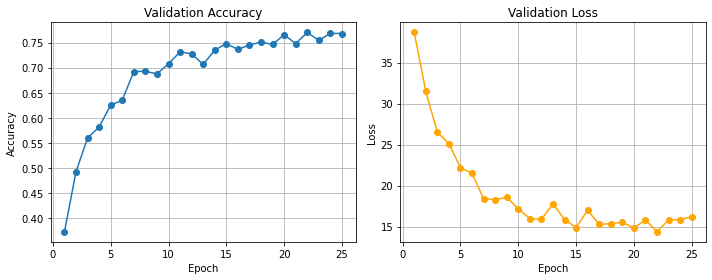

In [26]:
## 绘制损失函数图像

import matplotlib.pyplot as plt

epochs = list(range(1, len(accuracies)+1))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, losses, label='Test Loss', color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


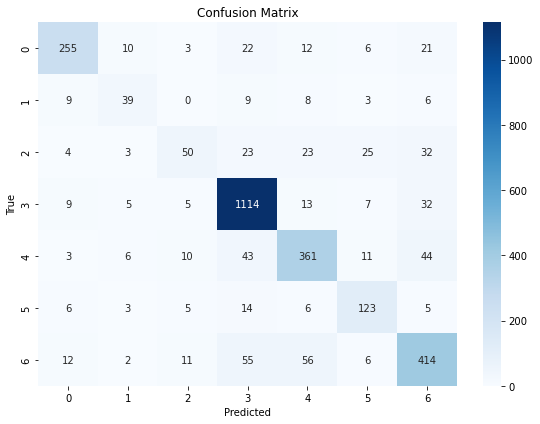

In [27]:
## 绘制confusion matirx
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, target in test_loader:
        img = img.cuda()
        target = target.cuda()
        output = model(img)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
labels = train_data.classes  # 类别名称

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
